In [35]:
# !pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.3.2 lightgbm==4.3.0
# !pip install imbalanced-learn==0.11.0 pyarrow fastparquet joblib tqdm matplotlib

import os, glob, warnings, joblib, random
import numpy as np, pandas as pd
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ==== PATHS (chỉnh theo máy bạn) ====
CIC2019_DIR = r'D:\DACN\dataset\CICDDoS2019'
CIC2017_DIR = r'D:\DACN\dataset\CICDDoS2017'
UNSW15_DIR  = r'D:\DACN\dataset\UNSW_NB15'
NSLKDD_DIR  = r'D:\DACN\dataset\NSL-KDD'   # có KDDTrain+.txt, KDDTest+.txt

# ==== loại cột ID/time ====
EXCLUDE_ID_COLUMNS = True
ID_LIKE_COLS = set([
    'Flow ID','FlowID','Timestamp','StartTime','Start Time','stime','time','Date','datetime',
    'Src IP','Dst IP','Source IP','Destination IP',
    'srcip','dstip','srcip_addr','dstip_addr', 
    'Src Port','Dst Port','Sport','Dport','srcport','dstport',
    'ProtocolName','ProtoName','Service','service','state','attack_cat','label',
    'Unnamed: 0','id','No.','Index'
])
LABEL_CANDS = ["Label","label","Attack","attack","attack_cat","class","Class","target","category","Category","result"]

# kiểm soát lệch phân bố từ UNSW (toàn attack)
MAX_UNSW_RATIO = 0.30   # tối đa 30% số mẫu DDoS từ UNSW trong tập gộp (đổi nếu muốn)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


In [36]:
def safe_read_any(path: str, nrows=None) -> pd.DataFrame:
    low = path.lower()
    try:
        if low.endswith(".parquet"):
            return pd.read_parquet(path) if nrows is None else pd.read_parquet(path).head(nrows)
        # NSL-KDD .txt không header
        if low.endswith(".txt") and ("kddtrain" in low or "kddtest" in low):
            df = pd.read_csv(path, header=None)
            if df.shape[1] == 43:
                cols = [f"feat_{i}" for i in range(41)] + ["label","difficulty"]
            elif df.shape[1] == 42:
                cols = [f"feat_{i}" for i in range(41)] + ["label"]
            else:
                cols = [f"col_{i}" for i in range(df.shape[1])]
            df.columns = cols
            return df if nrows is None else df.head(nrows)
        # csv chung
        for enc in ("utf-8-sig","utf-8","cp1252","latin1"):
            try:
                return pd.read_csv(path, encoding=enc, compression="infer", low_memory=False, nrows=nrows)
            except Exception:
                continue
        return pd.read_csv(path, compression="infer", low_memory=False, nrows=nrows)
    except Exception as e:
        print(f"[WARN] skip {os.path.basename(path)}: {e}")
        return pd.DataFrame()

def find_label_col(df: pd.DataFrame):
    for c in LABEL_CANDS:
        if c in df.columns: return c
    return None

# map AttackType như code gốc
attack_group_map = {
    'DrDoS_DNS':'DrDoS','DrDoS_SNMP':'DrDoS','DrDoS_NTP':'DrDoS','DrDoS_MSSQL':'DrDoS',
    'DrDoS_SSDP':'DrDoS','DrDoS_UDP':'DrDoS','TFTP':'TFTP',
    'UDP':'UDP','UDPLag':'UDP','Syn':'Syn','MSSQL':'MSSQL','LDAP':'LDAP',
    'DoS slowloris':'DoS','DoS Slowhttptest':'DoS','DoS Hulk':'DoS','DoS GoldenEye':'DoS',
    'Heartbleed':'Other',
    'Web Attack � Brute Force':'Web Attack','Web Attack � XSS':'Web Attack','Web Attack � Sql Injection':'Web Attack',
    'FTP-Patator':'Brute Force','SSH-Patator':'Brute Force','Infiltration':'Other','Bot':'Other',
    'PortScan':'PortScan','NetBIOS':'Other'
}

def normalize_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    lbl = find_label_col(df)
    if lbl is None:
        return pd.DataFrame()  # bỏ file không có nhãn
    df.rename(columns={lbl: "Label"}, inplace=True)
    df["Label"] = df["Label"].astype(str).str.strip()
    df.loc[df["Label"].str.lower().isin(["normal","benign","non-attack","good"]), "Label"] = "Benign"
    if "AttackType" not in df.columns:
        df["AttackType"] = df["Label"]
    def group_attack_type(x):
        if pd.isna(x): return 'Other'
        if x == 'Benign': return 'Benign'
        return attack_group_map.get(str(x), 'Other')
    df["AttackType"] = df["AttackType"].apply(group_attack_type)
    df["Label"] = df["Label"].apply(lambda v: 'Benign' if str(v)=='Benign' else 'DDoS')
    return df


In [37]:
# CIC-2019 train/test
cic19_train, cic19_test = [], []
for root,_,files in os.walk(CIC2019_DIR):
    for fn in files:
        if fn.endswith("-training.parquet"): cic19_train.append(os.path.join(root, fn))
        if fn.endswith("-testing.parquet"):  cic19_test.append(os.path.join(root, fn))

# CIC-2017 parquet
cic17_files = glob.glob(os.path.join(CIC2017_DIR, "**", "*.parquet"), recursive=True)

# UNSW: chỉ lấy các file có nhãn (bỏ *_features.csv, *_LIST_EVENTS.csv, *_GT.csv)
unsw_all = glob.glob(os.path.join(UNSW15_DIR, "**", "*.csv"), recursive=True)
unsw_files = [p for p in unsw_all if ("features" not in os.path.basename(p).lower()
                                      and "list_events" not in os.path.basename(p).lower()
                                      and not os.path.basename(p).lower().endswith("_gt.csv"))]

# NSL: chỉ .txt
nsl_all = glob.glob(os.path.join(NSLKDD_DIR, "**", "*.txt"), recursive=True)
nsl_files = [p for p in nsl_all if ("kddtrain" in os.path.basename(p).lower() or
                                    "kddtest" in os.path.basename(p).lower())]

print("CIC19 train:", len(cic19_train), "CIC19 test:", len(cic19_test))
print("CIC17:", len(cic17_files), "UNSW:", len(unsw_files), "NSL (txt):", len(nsl_files))

# union numeric + dataset_id
def infer_numeric_cols(files: List[str]) -> set:
    s = set()
    for p in files[:10]:
        head = safe_read_any(p, nrows=200)
        if head.empty: 
            continue
        head = normalize_labels(head)
        if head.empty: 
            continue
        cols = [c for c in head.columns if c not in ID_LIKE_COLS and c not in ("Label","AttackType")]
        for c in cols:
            if pd.api.types.is_numeric_dtype(head[c]):
                s.add(c)
    s.add("dataset_id")
    return s

union_cols = set()
union_cols |= infer_numeric_cols(cic19_train + cic19_test)
union_cols |= infer_numeric_cols(cic17_files)
union_cols |= infer_numeric_cols(unsw_files)
union_cols |= infer_numeric_cols(nsl_files)

FEATURES = sorted(list(union_cols))
print("Tổng số cột numeric union:", len(FEATURES))
joblib.dump({"feature_order": FEATURES}, "feature_order_union.pkl")


CIC19 train: 7 CIC19 test: 10
CIC17: 8 UNSW: 6 NSL (txt): 4
Tổng số cột numeric union: 156


['feature_order_union.pkl']

In [38]:
def load_and_normalize(files: List[str], dataset_id: int) -> pd.DataFrame:
    out = []
    for p in tqdm(files, desc=f"Load ds{dataset_id}"):
        df = safe_read_any(p)
        if df.empty: 
            continue
        df = normalize_labels(df)
        if df.empty:
            continue
        df["dataset_id"] = dataset_id
        out.append(df)
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

df17  = load_and_normalize(cic17_files, 1)
df19t = load_and_normalize(cic19_train, 2)
df19e = load_and_normalize(cic19_test, 2)    # chỉ để thống kê/valid nếu cần
dfUN  = load_and_normalize(unsw_files, 3)
dfNSL = load_and_normalize(nsl_files, 4)

print("Shapes:", {k:v.shape for k,v in {"CIC17":df17,"CIC19_train":df19t,"UNSW":dfUN,"NSL":dfNSL}.items()})

# gộp chính (CIC-2017 + CIC-2019 train)
df_main = pd.concat([df17, df19t], ignore_index=True)

# hạn chế UNSW (toàn attack) để không lấn át -> MAX_UNSW_RATIO * tổng DDoS hiện có
if not dfUN.empty:
    cur_ddos = (df_main["Label"]=="DDoS").sum()
    cap = int(MAX_UNSW_RATIO * max(1, cur_ddos))
    dfUN_ddos = dfUN[dfUN["Label"]=="DDoS"]
    if len(dfUN_ddos) > cap:
        dfUN_ddos = dfUN_ddos.sample(cap, random_state=RANDOM_STATE)
    dfUN = dfUN_ddos  # UNSW gần như toàn DDoS

# thêm NSL (có cả benign/attack)
df_all = pd.concat([df_main, dfUN, dfNSL], ignore_index=True)
assert not df_all.empty, "Không có dữ liệu!"

# thay NaN/Inf
df_all = df_all.replace([np.inf, -np.inf], np.nan).fillna(0)
print("Tổng mẫu sau gộp:", df_all.shape)


Load ds4: 100%|██████████| 4/4 [00:00<00:00,  9.08it/s]


Shapes: {'CIC17': (2313810, 80), 'CIC19_train': (125170, 80), 'UNSW': (257673, 47), 'NSL': (185559, 45)}
Tổng mẫu sau gộp: (2749109, 166)


In [39]:
# chọn numeric union
drop_cols = {'Label','AttackType'}
if EXCLUDE_ID_COLUMNS:
    drop_cols |= {c for c in df_all.columns if c in ID_LIKE_COLS}
feature_candidates = [c for c in FEATURES if c not in drop_cols and c in df_all.columns]
print("Số cột dùng:", len(feature_candidates))

X = df_all.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32)
y_bin = (df_all['Label'] != 'Benign').astype(int).values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bin
)
print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)

# scaler + SMOTE như gốc
scaler = MinMaxScaler()
scaler.fit(X_train_raw.values)
joblib.dump(scaler, 'scaler_union.pkl')

X_train_s = scaler.transform(X_train_raw.values)
X_test_s  = scaler.transform(X_test_raw.values)

sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train_s, y_train)
print("After SMOTE:", X_res.shape, "| pos_ratio:", y_res.mean().round(4))


Số cột dùng: 156
Train: (2199287, 156) Test: (549822, 156)
After SMOTE: (3386240, 156) | pos_ratio: 0.5


[✓] Epoch 1/3 — best_iter: 500
[✓] Epoch 2/3 — best_iter: 542
[✓] Epoch 3/3 — best_iter: 542


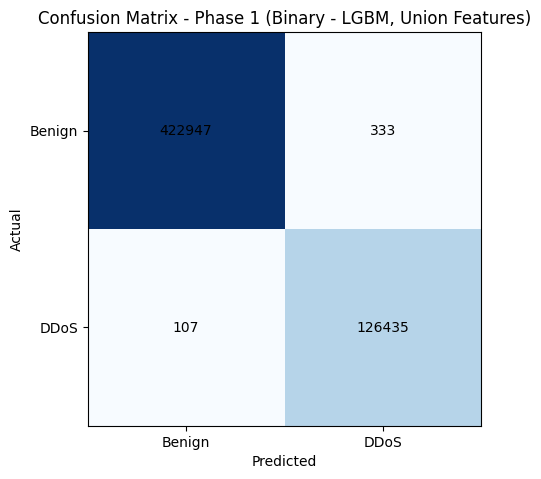

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    423280
        DDoS       1.00      1.00      1.00    126542

    accuracy                           1.00    549822
   macro avg       1.00      1.00      1.00    549822
weighted avg       1.00      1.00      1.00    549822

ROC-AUC: 0.9999899031971388


In [40]:
# bạn có thể tăng n_estimators từng "epoch" để nhẹ hơn
EPOCHS = 3
ROUND_PER_EPOCH = 500   # mỗi epoch tăng thêm 500 cây

clf_bin = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    class_weight='balanced',
    n_estimators=ROUND_PER_EPOCH,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=-1,
    # warm_start cho phép tăng n_estimators dần
    warm_start=True
)

for e in range(EPOCHS):
    clf_bin.n_estimators = (e+1)*ROUND_PER_EPOCH
    clf_bin.fit(
        X_res, y_res,
        eval_set=[(X_test_s, y_test)],
        eval_metric=['auc','binary_logloss'],
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )
    print(f"[✓] Epoch {e+1}/{EPOCHS} — best_iter: {clf_bin.best_iteration_}")

joblib.dump({'model': clf_bin, 'scaler': scaler, 'feature_order': feature_candidates},
            'lgbm_binary_union.joblib')

# đánh giá
y_prob = clf_bin.predict_proba(X_test_s)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues")
for (i,j),v in np.ndenumerate(cm): plt.text(j,i,str(v),ha="center",va="center")
plt.xticks([0,1],["Benign","DDoS"]); plt.yticks([0,1],["Benign","DDoS"])
plt.title("Confusion Matrix - Phase 1 (Binary - LGBM, Union Features)")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

print(classification_report(y_test, y_pred, target_names=['Benign','DDoS']))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Classes: ['Brute Force', 'DoS', 'LDAP', 'MSSQL', 'Other', 'PortScan', 'Syn', 'UDP', 'Web Attack']


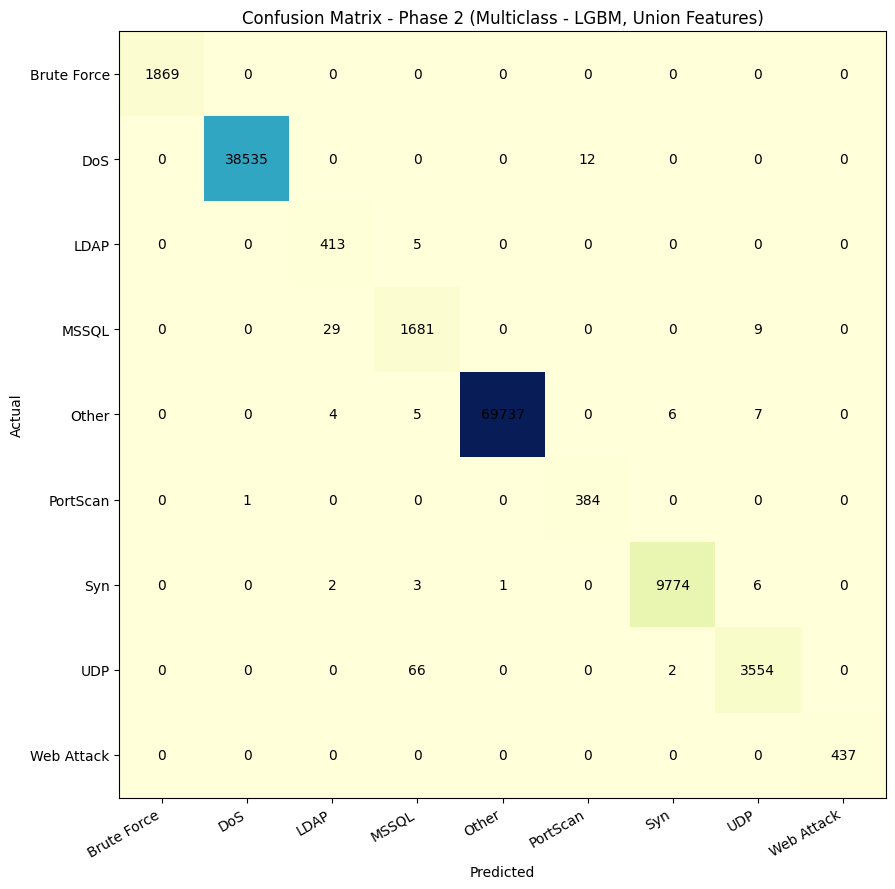

              precision    recall  f1-score   support

 Brute Force       1.00      1.00      1.00      1869
         DoS       1.00      1.00      1.00     38547
        LDAP       0.92      0.99      0.95       418
       MSSQL       0.96      0.98      0.97      1719
       Other       1.00      1.00      1.00     69759
    PortScan       0.97      1.00      0.98       385
         Syn       1.00      1.00      1.00      9786
         UDP       0.99      0.98      0.99      3622
  Web Attack       1.00      1.00      1.00       437

    accuracy                           1.00    126542
   macro avg       0.98      0.99      0.99    126542
weighted avg       1.00      1.00      1.00    126542



In [41]:
# lấy toàn bộ mẫu DDoS
df_attack = df_all[df_all['Label']=='DDoS'].copy()
X_attack = df_attack.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32).values
X_attack_s = scaler.transform(X_attack)

# nhãn đa lớp
y_attack_txt = df_attack['AttackType'].astype(str).values
le_attack = LabelEncoder()
y_attack = le_attack.fit_transform(y_attack_txt)
n_classes = len(le_attack.classes_)
joblib.dump(le_attack, "attack_label_encoder_union.pkl")
print("Classes:", list(le_attack.classes_))

# SMOTE đa lớp
X_attack_res, y_attack_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_attack_s, y_attack)

# chia train/test theo stratified
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(
    X_attack_res, y_attack_res, test_size=0.2, random_state=RANDOM_STATE, stratify=y_attack_res
)

# trọng số theo tần suất đảo để ổn định hơn
counts = pd.Series(ya_tr).value_counts()
inv_ratio = counts.max() / counts
sample_weight = pd.Series(ya_tr).map(inv_ratio).values

clf_multi = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=n_classes,
    n_estimators=1600,
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

clf_multi.fit(
    Xa_tr, ya_tr,
    sample_weight=sample_weight,
    eval_set=[(Xa_te, ya_te)],
    eval_metric=['multi_logloss'],
    callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
)

joblib.dump({
    'model': clf_multi,
    'scaler': scaler,
    'feature_order': feature_candidates,
    'attack_label_encoder': le_attack
}, 'lgbm_attack_union.joblib')

# Đánh giá trên phần DDoS thuộc tập test của Cell 5
test_mask_ddos = (y_test == 1)
X_attack_test = X_test_s[test_mask_ddos]
y_attack_test_txt = df_all.iloc[X_test_raw.index][test_mask_ddos]['AttackType'].astype(str).values  # tương ứng order

# map nhãn test -> encoder
y_attack_test = []
for t in y_attack_test_txt:
    if t in le_attack.classes_:
        y_attack_test.append(le_attack.transform([t])[0])
    else:
        # nếu có nhãn lạ → gộp "Other" nếu tồn tại, ngược lại bỏ
        if "Other" in le_attack.classes_:
            y_attack_test.append(le_attack.transform(["Other"])[0])
        else:
            # bỏ trường hợp hiếm không map được
            y_attack_test.append(-1)
y_attack_test = np.array([v for v in y_attack_test if v >= 0])

# dự đoán
y_attack_pred = clf_multi.predict(X_attack_test[:len(y_attack_test)])

labels_multi = le_attack.classes_
cm2 = confusion_matrix(y_attack_test, y_attack_pred)
plt.figure(figsize=(12,9))
plt.imshow(cm2, cmap='YlGnBu')
for (i,j),v in np.ndenumerate(cm2): plt.text(j,i,str(v),ha="center",va="center")
plt.xticks(range(len(labels_multi)), labels_multi, rotation=30, ha="right")
plt.yticks(range(len(labels_multi)), labels_multi)
plt.title("Confusion Matrix - Phase 2 (Multiclass - LGBM, Union Features)")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

print(classification_report(y_attack_test, y_attack_pred, target_names=labels_multi))
